In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import shap
import os


from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, OneHotEncoder, FunctionTransformer, PolynomialFeatures,MaxAbsScaler,MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,StackingRegressor, StackingClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, SelectFromModel
from xgboost import XGBClassifier,XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D


import warnings
warnings.filterwarnings('ignore')



from google.colab import drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Contest/Fertilizers/train.csv')
df.head(10)

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP
5,5,30,59,29,Red,Pulses,10,0,9,20-20
6,6,27,62,53,Sandy,Paddy,26,15,22,28-28
7,7,36,62,44,Red,Pulses,30,12,35,14-35-14
8,8,36,51,32,Loamy,Tobacco,19,17,29,17-17-17
9,9,28,50,35,Red,Tobacco,25,12,16,20-20


In [35]:
df.shape

(750000, 10)

In [36]:
dfc=df.copy()

In [37]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
dfc['Soil Type']=le.fit_transform(dfc['Soil Type'])
dfc['Crop Type']=le.fit_transform(dfc['Crop Type'])
dfc['Fertilizer Name']=le.fit_transform(dfc['Fertilizer Name'])


dfc['n_h_ratio'] = dfc['Nitrogen']**2/np.log(dfc['Humidity'])
dfc['p_h_ratio'] = dfc['Potassium']**2/np.log(dfc['Humidity'])
dfc['k_h_ratio'] = dfc['Phosphorous']**2/np.log(dfc['Humidity'])
dfc['n_m_ratio'] = dfc['Nitrogen']**2/np.log(dfc['Moisture'])
dfc['p_m_ratio'] = dfc['Potassium']**2/np.log(dfc['Moisture'])
dfc['k_m_ratio'] = dfc['Phosphorous']**2/np.log(dfc['Moisture'])
dfc['THM']=dfc['Temparature']*dfc['Humidity']*dfc['Moisture']
dfc['NPP']=dfc['Nitrogen']*dfc['Phosphorous']*dfc['Potassium']

In [38]:
dfc.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name,n_h_ratio,p_h_ratio,k_h_ratio,n_m_ratio,p_m_ratio,k_m_ratio,THM,NPP
0,0,37,70,36,1,8,36,4,5,4,305.049182,3.766039,5.884436,361.655686,4.464885,6.976383,93240,720
1,1,27,69,65,4,4,30,6,18,4,212.559604,8.502384,76.521457,215.600504,8.624020,77.616182,121095,3240
2,2,29,63,32,4,4,24,12,16,2,139.025168,34.756292,61.788963,166.198469,41.549617,73.865986,58464,4608
3,3,35,62,54,4,0,39,12,4,0,368.536582,34.891037,3.876782,381.300096,36.099417,4.011046,117180,1872
4,4,35,58,43,3,6,37,2,16,5,337.155329,0.985114,63.047308,363.979570,1.063490,68.063382,87290,1184


In [39]:
X=dfc.drop(['Fertilizer Name','id'],axis=1)
y=dfc['Fertilizer Name']

In [40]:
X_train,X_cv,y_train,y_cv=train_test_split(X,y,random_state=42,test_size=0.2)

In [41]:
X_train.shape

(600000, 16)

In [42]:
len(le.classes_)

7

In [43]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               750000 non-null  int64  
 1   Temparature      750000 non-null  int64  
 2   Humidity         750000 non-null  int64  
 3   Moisture         750000 non-null  int64  
 4   Soil Type        750000 non-null  int64  
 5   Crop Type        750000 non-null  int64  
 6   Nitrogen         750000 non-null  int64  
 7   Potassium        750000 non-null  int64  
 8   Phosphorous      750000 non-null  int64  
 9   Fertilizer Name  750000 non-null  int64  
 10  n_h_ratio        750000 non-null  float64
 11  p_h_ratio        750000 non-null  float64
 12  k_h_ratio        750000 non-null  float64
 13  n_m_ratio        750000 non-null  float64
 14  p_m_ratio        750000 non-null  float64
 15  k_m_ratio        750000 non-null  float64
 16  THM              750000 non-null  int6

In [44]:
from sklearn.metrics import make_scorer

def mapk(actual,predicted,k=3):
    score=0.0
    for true,preds in zip(actual,predicted):
        for i,pred in enumerate(preds[:k]):
            if pred==true:
                score+=1/(i+1)
                break
    return score/len(actual)
def map3_scorer(estimator,X,y):
    y_probs=estimator.predict_proba(X)
    top_3=np.argsort(y_probs,axis=1)[:,-3:][:,::-1]
    too_3_labels=[[estimator.classes_[j] for j in row]for row in top_3]
    return mapk(y,too_3_labels,k=3)
map3_score=make_scorer(map3_scorer,greater_is_better=True)

In [45]:
pipe=Pipeline([
    ('scaler',StandardScaler()),
    ('model',XGBClassifier(
        objective='multi:softprob',num_class=7,eval_metric='mlogloss',use_label_encoder=False
        ))
])

In [ ]:
import scipy.stats as stats
pram_grid={
    'model__n_estimators':[50,100,200],
    'model__max_depth':stats.randint(4,10),
    'model__learning_rate':[0.01,0.1,0.3],
    'model__reg_lambda':[0.01,0.1,1,10,100],
    'model__reg_alpha':[0.01,0.1,1,10,100],
    'scaler':[StandardScaler(),RobustScaler(),MaxAbsScaler(),MinMaxScaler()]
}

grid=RandomizedSearchCV(pipe,pram_grid,cv=5,n_jobs=-1,verbose=1,scoring=map3_score)
grid.fit(X,y)

In [ ]:
grid.best_params_

{'model__learning_rate': 0.01,
 'model__max_depth': 5,
 'model__n_estimators': 100,
 'model__reg_alpha': 100,
 'model__reg_lambda': 0.1,
 'scaler': RobustScaler()}

In [46]:
fit_params={
    'model__early_stopping_rounds':100,
    'model__verbose':10,
    'model__n_estimators':20000,
    'model__reg_alpha':2.7,
    'model__reg_lambda':1.4,
    'model__gamma':0.26,
    'model__max_delta_step':4,
    'scaler':RobustScaler(),
    'model__random_state':13,
    'model__eval_metric':'mlogloss',
    'model__objective': 'multi:softprob',
    'model__max_depth': 7,
    'model__learning_rate': 0.062,
    'model__subsample': 0.8,
    'model__tree_method':'hist',
    'model__device':'cuda'
}

In [47]:
pipe.set_params(**fit_params)
scale=StandardScaler()
X_cv=scale.fit_transform(X_cv)
y_train=le.fit_transform(y_train)
y_cv=le.transform(y_cv)
pipe.fit(X_train,y_train,model__eval_set=[(X_cv,y_cv)])

[0]	validation_0-mlogloss:1.94559
[1]	validation_0-mlogloss:1.94533
[2]	validation_0-mlogloss:1.94505
[3]	validation_0-mlogloss:1.94483
[4]	validation_0-mlogloss:1.94463
[5]	validation_0-mlogloss:1.94447
[6]	validation_0-mlogloss:1.94439
[7]	validation_0-mlogloss:1.94423
[8]	validation_0-mlogloss:1.94414
[9]	validation_0-mlogloss:1.94409
[10]	validation_0-mlogloss:1.94400
[11]	validation_0-mlogloss:1.94396
[12]	validation_0-mlogloss:1.94391
[13]	validation_0-mlogloss:1.94386
[14]	validation_0-mlogloss:1.94385
[15]	validation_0-mlogloss:1.94386
[16]	validation_0-mlogloss:1.94380
[17]	validation_0-mlogloss:1.94384
[18]	validation_0-mlogloss:1.94388
[19]	validation_0-mlogloss:1.94387
[20]	validation_0-mlogloss:1.94386
[21]	validation_0-mlogloss:1.94389
[22]	validation_0-mlogloss:1.94389
[23]	validation_0-mlogloss:1.94395
[24]	validation_0-mlogloss:1.94399
[25]	validation_0-mlogloss:1.94405
[26]	validation_0-mlogloss:1.94409
[27]	validation_0-mlogloss:1.94415
[28]	validation_0-mlogloss:1.9

Pipeline(steps=[('scaler', RobustScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device='cuda',
                               early_stopping_rounds=100,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=0.26, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.062, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=4, max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=20000, n_jobs=None, num_class=7,
                               num_parallel_tree=None, ...))])

In [48]:
X_train.shape

(600000, 16)

In [49]:
y_pred_cv=pipe.predict_proba(X_cv)
top_3=np.argsort(y_pred_cv,axis=1)[:,-3:][:,::-1]
y_pred_cv=[[le.classes_[j] for j in row]for row in top_3]
y_cv=le.inverse_transform(y_cv)
print(mapk(y_cv,y_pred_cv))

0.275093333333349


In [50]:
print(y_cv[2])
print(y_pred_cv[2])

0
[np.int64(1), np.int64(4), np.int64(2)]


In [51]:
y_pred_train_prob=pipe.predict_proba(X_train)
top_3=np.argsort(y_pred_train_prob,axis=1)[:,-3:][:,::-1]
y_pred_train=[[le.classes_[j] for j in row]for row in top_3]
y_train=le.inverse_transform(y_train)
print(mapk(y_train,y_pred_train))

0.32545611111139294


In [52]:
print(y_train[1])
print(y_pred_train[1])
print(top_3[1])
print(y_pred_train_prob[1])

3
[np.int64(4), np.int64(3), np.int64(6)]
[4 3 6]
[0.13862212 0.14136438 0.1415069  0.14487201 0.1491823  0.14090751
 0.14354481]


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

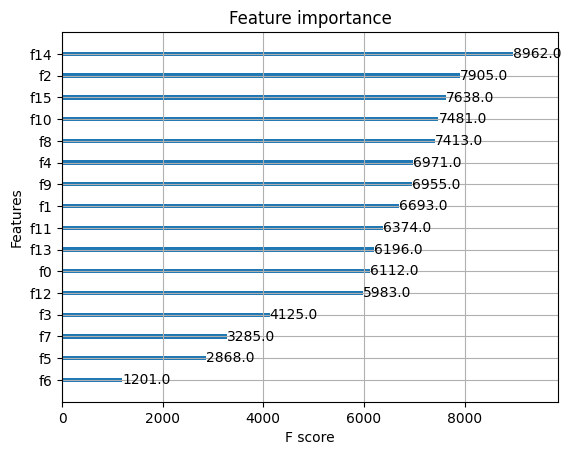

In [53]:
model=pipe.named_steps['model']
plot_importance(model)

In [54]:
X.shape

(750000, 16)

# Neural Network


In [ ]:
model_n=Sequential([
    tf.keras.layers.Input(shape=(X.shape[1],)),
    Dense(256,activation='relu'),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(7,activation='linear')
],name='model_2')
model_n.summary()

Model: "model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,767 (178.78 KB)

 Trainable params: 45,767 (178.78 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_n.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy']
)

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [ ]:
model_n.fit(
    X_train,y_train,
    validation_data=(X_cv,y_cv),
    batch_size=32,
    epochs=100,
    callbacks=[callback],
    verbose=1
)

Epoch 1/100
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.1507 - loss: 1.9532 - val_accuracy: 0.1509 - val_loss: 1.9425
Epoch 2/100
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - accuracy: 0.1499 - loss: 1.9439 - val_accuracy: 0.1518 - val_loss: 1.9429
Epoch 3/100
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - accuracy: 0.1506 - loss: 1.9435 - val_accuracy: 0.1467 - val_loss: 1.9429
Epoch 4/100
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.1501 - loss: 1.9437 - val_accuracy: 0.1467 - val_loss: 1.9436
Epoch 5/100
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.1500 - loss: 1.9438 - val_accuracy: 0.1467 - val_loss: 1.9427
Epoch 6/100
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - accuracy: 0.1508 - loss: 1.9438 - val_accuracy: 0.1509 - val_loss: 1.9434
Epoch 7/100
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - accuracy: 0.1507 - loss: 1.9437 - val_accuracy: 0.1523 - val_loss: 1.9437
Epoch 8/100
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - ac

In [ ]:
y_pred_cv=model_n.predict(X_cv)
top_3=np.argsort(y_pred_cv,axis=1)[:,-3:][:,::-1]
y_pred_cv=[[le.classes_[j] for j in row]for row in top_3]
y_cv=le.inverse_transform(y_cv)
print(mapk(y_cv,y_pred_cv))

4688/4688 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
0.27654888888890783


In [ ]:
print(y_cv[2])
print(y_pred_cv[2])

10-26-26
['14-35-14', '17-17-17', '28-28']


In [ ]:
y_pred_train=model_n.predict(X_train)
top_3=np.argsort(y_pred_train,axis=1)[:,-3:][:,::-1]
y_pred_train=[[le.classes_[j] for j in row]for row in top_3]
y_train=le.inverse_transform(y_train)
print(mapk(y_train,y_pred_train))

18750/18750 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step
0.27705472222230787


In [ ]:
print(y_train[1])
print(y_pred_train[1])
print(top_3[1])
print(y_pred_train[1])

20-20
['14-35-14', '17-17-17', '28-28']
[1 2 4]
['14-35-14', '17-17-17', '28-28']


# Submit

In [55]:
test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Contest/Fertilizers/test.csv')
test.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous
0,750000,31,70,52,Sandy,Wheat,34,11,24
1,750001,27,62,45,Red,Sugarcane,30,14,15
2,750002,28,72,28,Clayey,Ground Nuts,14,15,4
3,750003,37,53,57,Black,Ground Nuts,18,17,36
4,750004,31,55,32,Red,Pulses,13,19,14


In [56]:
le=LabelEncoder()
dfc['Fertilizer Name']=le.fit_transform(df['Fertilizer Name'])

In [57]:
le.classes_

array(['10-26-26', '14-35-14', '17-17-17', '20-20', '28-28', 'DAP',
       'Urea'], dtype=object)

In [59]:
le_test=LabelEncoder()
test['Soil Type']=le_test.fit_transform(test['Soil Type'])
test['Crop Type']=le_test.fit_transform(test['Crop Type'])

test['n_h_ratio'] = test['Nitrogen']**2/np.log(test['Humidity'])
test['p_h_ratio'] = test['Potassium']**2/np.log(test['Humidity'])
test['k_h_ratio'] = test['Phosphorous']**2/np.log(test['Humidity'])
test['n_m_ratio'] = test['Nitrogen']**2/np.log(test['Moisture'])
test['p_m_ratio'] = test['Potassium']**2/np.log(test['Moisture'])
test['k_m_ratio'] = test['Phosphorous']**2/np.log(test['Moisture'])
test['THM']=test['Temparature']*test['Humidity']*test['Moisture']
test['NPP']=test['Nitrogen']*test['Phosphorous']*test['Potassium']

In [60]:
X=test.drop(['id'],axis=1)

In [61]:
y_pred=pipe.predict_proba(X)
top_3=np.argsort(y_pred,axis=1)[:,-3:][:,::-1]

In [62]:
top3_labels = le.inverse_transform(top_3.ravel()).reshape(top_3.shape)

In [63]:
top3_strings = [' '.join(row) for row in top3_labels]

In [64]:
print(top3_strings[0])

28-28 14-35-14 17-17-17


In [65]:
submission = pd.DataFrame({
    'id': test['id'],
    'Fertilizer Name': top3_strings
})


In [66]:
submission.to_csv('submission.csv', index=False)
